In [1]:
from train_gpt2_dalle2 import fetch_models

import torch
import torchvision.transforms as T
from transformers import GPT2Tokenizer, GPT2LMHeadModel

import sys
sys.path.append('dalle2-laion')
from dalle2_laion.scripts import InferenceScript
from dalle2_laion import DalleModelManager, ModelLoadConfig

/fsx/home-shivr/general-gpt_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
inference = InferenceScript.create('dalle2-laion/configs/upsampler.example.json')

### Direct Inference

In [19]:
image_embed = inference._sample_prior(["horses in a field", "another random one"], cond_scale=None, sample_count=1, batch_size=100, num_samples_per_batch=2)

sampling loop time step: 100%|██████████| 64/64 [00:01<00:00, 49.46it/s]


In [35]:
torch.stack(list(map(lambda x: x[0], image_embed.values())), dim=0).size()

torch.Size([2, 768])

In [8]:
image_embeddings = []
image_embeddings.extend(image_embed[0])
image = inference._sample_decoder(text=["horses in a field"], image_embed=image_embeddings, cond_scale=None, sample_count=1, batch_size=10)

0it [00:00, ?it/s]
sampling loop time step:  21%|██        | 206/1000 [00:30<01:42,  7.74it/s]


sampling loop time step:  41%|████      | 412/1000 [00:57<01:19,  7.39it/s]


sampling loop time step:  62%|██████▏   | 618/1000 [01:25<00:50,  7.60it/s]


sampling loop time step:  82%|████████▏ | 824/1000 [01:52<00:23,  7.50it/s]


sampling loop time step: 100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]
1it [02:21, 141.60s/it]
sampling loop time step:   6%|▌         | 57/1000 [00:03<01:05, 14.42it/s]


sampling loop time step:  47%|████▋     | 469/1000 [00:32<00:37, 14.34it/s]


sampling loop time step:  88%|████████▊ | 881/1000 [01:01<00:08, 14.40it/s]


sampling loop time step: 100%|██████████| 1000/1000 [01:09<00:00, 14.38it/s][A
2it [03:37, 108.60s/it]


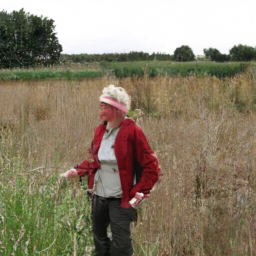

In [12]:
display(image[0][0])

### Using GPT2

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("../pretrained/gpt2-cc3m-prior")
model.eval()
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [11]:
def generate_image(text, model, tokenizer, inference, k=5):
    model.eval()

    with torch.no_grad():
        outputs = model.generate(**tokenizer(text, return_tensors='pt').to(device), return_dict_in_generate=True, output_hidden_states=True, max_new_tokens=50)

        print("Output text: ", tokenizer.decode(outputs['sequences'][0]))

        pred_emb = outputs['hidden_states'][-1][-1][:,-1,:].squeeze(0)
        
        images = inference._sample_decoder(text=[text], image_embed=[pred_emb], cond_scale=None, sample_count=1, batch_size=10)
    
    return images

In [12]:
text = "A photo of a valley from a mountain top at sunset."
images = generate_image(text, model, tokenizer, inference)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output text:  A photo of a valley from a mountain top at sunset.<|endoftext|>


0it [00:00, ?it/s]
sampling loop time step:  10%|█         | 103/1000 [00:17<02:35,  5.76it/s]


sampling loop time step:  21%|██        | 206/1000 [00:35<02:16,  5.81it/s]


sampling loop time step:  31%|███       | 309/1000 [00:53<02:00,  5.74it/s]


sampling loop time step:  41%|████      | 412/1000 [01:11<01:41,  5.81it/s]


sampling loop time step:  52%|█████▏    | 515/1000 [01:28<01:08,  7.12it/s]


sampling loop time step:  62%|██████▏   | 618/1000 [01:42<00:53,  7.08it/s]


sampling loop time step:  72%|███████▏  | 721/1000 [01:59<00:39,  7.02it/s]


sampling loop time step:  82%|████████▏ | 824/1000 [02:14<00:24,  7.10it/s]


sampling loop time step:  93%|█████████▎| 927/1000 [02:28<00:10,  7.07it/s]


sampling loop time step: 100%|██████████| 1000/1000 [02:39<00:00,  6.29it/s]
1it [02:42, 162.84s/it]
sampling loop time step:   6%|▌         | 58/1000 [00:03<01:05, 14.48it/s]


sampling loop time step:  26%|██▋       | 264/1000 [00:18<00:50, 14.49it/s]


sampling loop time step:  47%|████▋     | 470/1000 [00:33<00:40, 13.07it/s]


sampling loop time step:  68%|██████▊   | 676/1000 [00:48<00:24, 13.15it/s]


sampling loop time step:  88%|████████▊ | 882/1000 [01:04<00:08, 13.12it/s]


sampling loop time step: 100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]
2it [04:01, 120.85s/it]


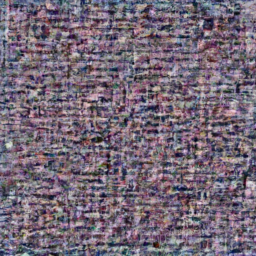

In [13]:
display(images[0][0])